In [1]:
import numpy as np
import math
import os
import pygmt
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('./src')
from ridgetools import *

In [2]:
def get_crack_load_one_model(ridgeFile):
    myRidge = load_ridge_csv(ridgeFile)
    n = myRidge.shape[0]
    ridgeAzi = get_ridge_azimuth(myRidge)
    ridgeLoading = np.zeros((n,))

    for ii in range(0,n):
        onePoint = myRidge.iloc[ii,:]
        ridgeLoading[ii] = get_loading_stress(onePoint,ridgeAzi)
    x = lonlat2x(myRidge)
    return x, ridgeLoading

def get_ridge_eqrk_topo(ridgeFile,gridFile):
    myRidge = load_ridge_csv(ridgeFile)
    ridge_eqrk_topo = pygmt.grdtrack(myRidge.iloc[:,0:2],gridFile,newcolname='depth')
    ridge_eqrk_topo = ridge_eqrk_topo.iloc[:,-1]
    return ridge_eqrk_topo

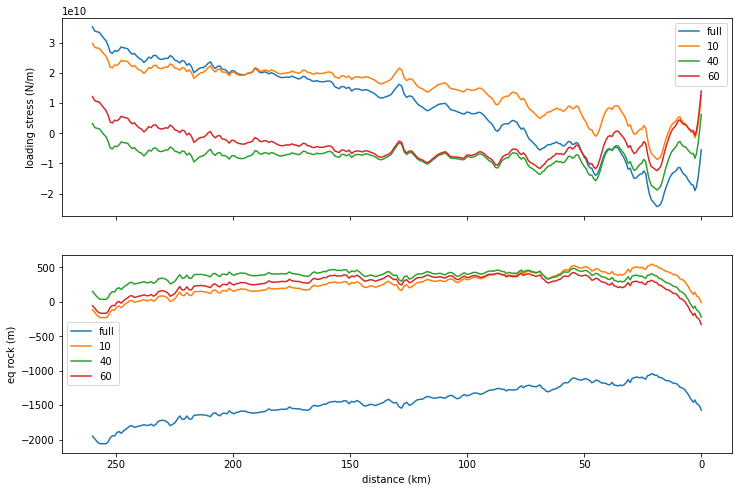

In [12]:
gridDirPrefix = 'stress_grds/'
gridDirList = ['extended/','extended_filt_10/','extended_filt_40/','extended_filt_60/']
topoDir = '/Users/huharper/03_topo-stress/'
topoList = ['galapagos.extended.nc','galapagos.extended.1.10.nc',
           'galapagos.extended.40.50.nc','galapagos.extended.60.70.nc']
labels = ['full','10','40','60']

fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
for grid,topo,label in zip(gridDirList,topoList,labels):
    myFile = gridDirPrefix + grid + 'galapagos-west.txt'
    myGrid = topoDir + topo
    topo = get_ridge_eqrk_topo(myFile,myGrid)
    x, ridgeLoading = get_crack_load_one_model(myFile)
    ax[0].plot(x*1e-3,ridgeLoading,label=label)
    ax[1].plot(x*1e-3,topo,label=label)

ax[0].set_ylabel('loading stress (N/m)')
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel('eq rock (m)')
ax[1].set_xlabel('distance (km)')
ax[0].invert_xaxis()

What's the result of extending the region? Well, if the region is extended and the input hasn't been filtered, then longer wavelengths will be captured and the computed stress will change. However, if we've already high-pass filtered the inputs, we should not get a different result.

I am thinking, to match the PM&P topography, we need to remove only the very lowest wavelengths. Remove up to SH \#10, about 4000 km

---
### old

In [26]:
KFull = compute_K(x,ridgeLoadingFull)
KFullExt = compute_K(x,ridgeLoadingFullExt)
K60 = compute_K(x,ridgeLoading60)
K10 = compute_K(x,ridgeLoading10Ext)

print('Unfiltered input           : K = {:e} Pa m^(1/2)'.format(KFull))
print('Unfiltered input, extended : K = {:e} Pa m^(1/2)'.format(KFullExt))
print('60-70 Filtered, extended   : K = {:e} Pa m^(1/2)'.format(K60))
print('1-10 Filtered, extended    : K = {:e} Pa m^(1/2)'.format(K10))

Unfiltered input           : K = 2.897436e+09 Pa m^(1/2)
Unfiltered input, extended : K = 1.335094e+09 Pa m^(1/2)
60-70 Filtered, extended   : K = -1.907558e+08 Pa m^(1/2)
1-10 Filtered, extended    : K = 1.435436e+09 Pa m^(1/2)
